## EDA - Events & Sessions datasets
- Session = when a user is on the app
- Event = what a user did on the app

In [17]:
import pandas as pd
import nump as np
import matplotlib.pyplot as plt
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import IntegerType

In [2]:
sc = SparkContext.getOrCreate()
ss = SparkSession.builder.getOrCreate()

In [3]:
users = pd.read_csv('data/user_dict.csv', header=None)
user_dict = {row[1][0]:int(row[1][1]) for row in users.iterrows()}

In [4]:
# Load mapping of user_id_hash to user_id
name = 'user_id_hash'
fn = UserDefinedFunction(lambda x: user_dict[x], IntegerType())

In [65]:
# Load events data, map id_hash to user_id, show first few rows
df = ss.read.csv('data/events.csv', header=True, inferSchema=True)
df = df.withColumn('user_id', fn(df.user_id_hash))\
        .drop('user_id_hash', 'app_id', 'session_id')
df.show(5)

+------------------+---------------+-----------+-------+
|             event|event_timestamp|event_value|user_id|
+------------------+---------------+-----------+-------+
|                45|  1542215397132|        0.0| 554721|
|                45|  1542215484895|        0.0| 554721|
|.m5100869650219008|  1541124410372|        0.0| 554721|
|                 4|  1543713091129|        0.0| 554721|
|                 6|  1543713093116|        0.0| 554721|
+------------------+---------------+-----------+-------+
only showing top 5 rows



In [12]:
# Count number of events
df.count()

111946597

In [15]:
# Count number of distinct events
df.select('event').distinct().count()

109

In [73]:
# Count number of distinct user_ids
df.select('user_id').distinct().count()

621001

In [16]:
# Group by event and count of top events
df.groupby(df.event).count().orderBy('count',ascending=False).show()

+------------------+--------+
|             event|   count|
+------------------+--------+
|                45|75493931|
|                 1| 5363926|
|                 5| 4887922|
|                 6| 4068474|
|                14| 3491117|
|                 4| 3435363|
|                40| 2775997|
|                 7| 1970903|
|                41| 1969223|
|                 3| 1828494|
|                42| 1598212|
|.a5027911885258752|  618037|
|.a5400102822346752|  604699|
|                44|  495590|
|.a5516611293544448|  411053|
|                 0|  407118|
|                63|  347198|
|                47|  310038|
|                57|  271268|
|                 8|  265034|
+------------------+--------+
only showing top 20 rows



### Purchases

In [72]:
# Filter for purchases, get date, and count of purchases
purchases = df.filter("event == 8").toPandas()
from datetime import datetime
purchases['datetime'] = purchases['event_timestamp']\
                        .apply(lambda x:datetime.fromtimestamp(x/1000))
purchases = purchases[purchases['event_value'] != 0]
purchases.count()

event              265017
event_timestamp    265017
event_value        265017
user_id            265017
datetime           265017
dtype: int64

Text(0, 0.5, 'Number of Purchases')

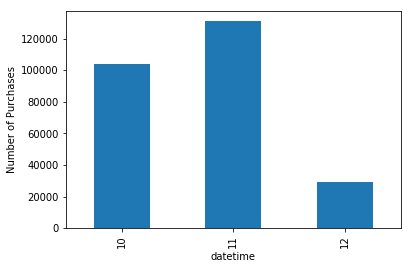

In [71]:
# Plot purchase count by month
purchases.groupby(purchases["datetime"].dt.month)['event'].count().plot(kind="bar")
plt.ylabel('Number of Purchases')

Text(0, 0.5, 'Number of Purchases')

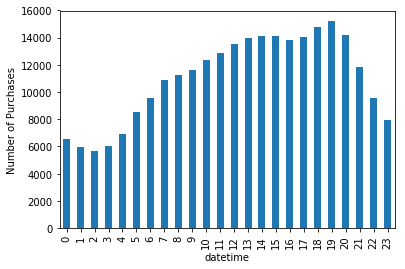

In [70]:
# Purchases by hour of the day
purchases.groupby(purchases["datetime"].dt.hour)['event'].count().plot(kind="bar")
plt.ylabel('Number of Purchases')

Text(0, 0.5, 'Number of Users')

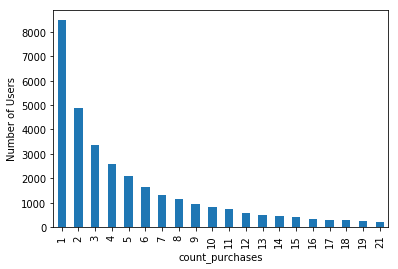

In [68]:
# Count of users by number of purchases - top 20
user_purchases = purchases.groupby(purchases.user_id)['event']\
        .count().reset_index()
user_purchases.columns = ['user_id', 'count_purchases']
user_purchases.groupby(user_purchases.count_purchases)['user_id']\
        .count().sort_values(ascending=False)\
        .iloc[:20].plot(kind='bar')
plt.ylabel('Number of Users')

Text(0, 0.5, 'Number of Users')

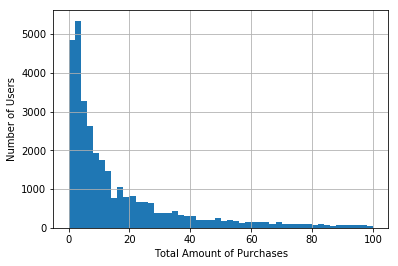

In [75]:
# Group by user and compute sum of total purchases
user_purchase_sum = purchases.groupby(purchases.user_id)['event_value']\
        .sum().reset_index()

# Plot histogram of users by total amount purchases
user_purchase_sum.event_value.hist(bins=50, range=[0,100])
plt.xlabel('Total Amount of Purchases')
plt.ylabel('Number of Users')

### Adding in Sessions data

In [ ]:
# load sessions data, drop irrelevant columns
df0 = pd.read_csv("data/sessions.csv")
df0.drop(['app_id',"device_id","latitude","longitude",
         'is_wau','is_mau','timezone',
         'timezone_offset','os_name','locale','session_id'], axis=1, inplace=True)

In [ ]:
# create day of week, month, day from start_timestamp
df['start_timestamp'] = df['start_timestamp'].apply(lambda x:datetime.fromtimestamp(x/1000))
df['user_created_timestamp'] = df['user_created_timestamp'].apply(lambda x:datetime.fromtimestamp(x/1000))

df['st_weekday']=df['start_timestamp'].dt.weekday
df['st_month']=df['start_timestamp'].dt.month
df['st_day']=df['start_timestamp'].dt.day

/Users/evan/anaconda3/envs/MSDS694/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  


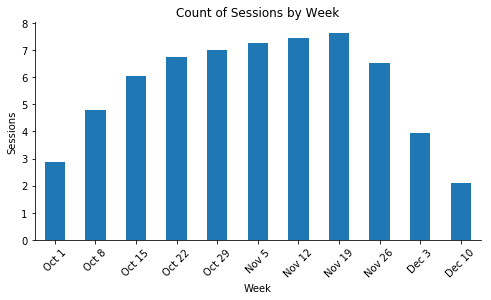

In [33]:
# Count of sessions by week
df2 = df.set_index('start_timestamp')['cr_from_now']
df3 = df2.resample('1W', how='count')
labels = ['Oct 1', 'Oct 8', 'Oct 15', 'Oct 22', 'Oct 29', 'Nov 5', 'Nov 12', 'Nov 19',
         'Nov 26', 'Dec 3', 'Dec 10']

# create an index for each tick position
xi = [i for i in range(0, len(df3))]
yi = [i for i in range(0, max(df3)+100000, 100000)]

fig, ax = plt.subplots(figsize=(8,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
df3.plot(kind='bar')
plt.xlabel('Week')
plt.ylabel('Sessions')
ylabels = range(9)
plt.xticks(xi, labels=labels)
plt.yticks(yi, labels=ylabels)
plt.xticks(rotation=45)
plt.title('Count of Sessions by Week')
plt.show()

In [ ]:
# Compute count of sessions by hour
df_new = df.groupby(df["start_timestamp"].dt.hour)['st_weekday'].count()
max_sessions = max(df_new)
df_new = df_new/max_sessions
df_new.plot(kind="bar")
plt.ylabel('Number of Sessions')

### Interrelation between sessions and purchases

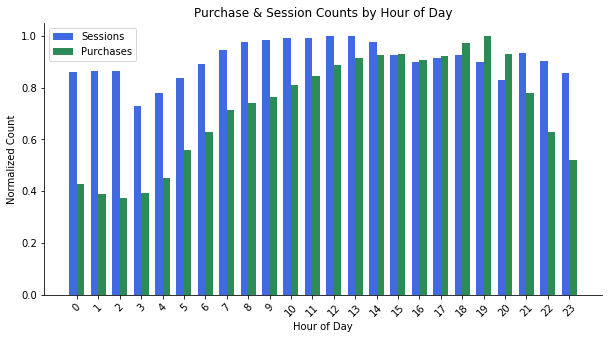

In [117]:
# Plot normalized count of sessions and purchases by hour of the day
N = 24
ind = np.arange(N)  # x locations for the groups
width = 0.35       # width of the bars
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, df_new, width, color='royalblue')
rects2 = ax.bar(ind+width, purchases2, width, color='seagreen')

# plot formatting
ax.set_ylabel('Normalized Count')
ax.set_xlabel('Hour of Day')
ax.set_title('Purchase & Session Counts by Hour of Day')
ax.set_xticks(ind + width / 2)
plt.xticks(rotation=45)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticklabels(range(N))
ax.legend( (rects1[0], rects2[0]), ('Sessions', 'Purchases') )

plt.show()